In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import numpy as np
from optimizer_supervised import Optimizer
from Ising import Ising
from model import TransformerModel

In [3]:
def gpu_setup():
    # Setup for PyTorch:
    if torch.cuda.is_available():
        torch_device = torch.device("cuda")
        print("PyTorch is using GPU {}".format(torch.cuda.current_device()))
    else:
        torch_device = torch.device("cpu")
        print("GPU unavailable; using CPU")

In [4]:
torch.set_default_device("cuda")

In [5]:
# Specify "cpu" or "cuda" as the device
system_sizes = torch.arange(2, 21, 2, device="cpu").reshape(-1, 1)
system_sizes

tensor([[ 2],
        [ 4],
        [ 6],
        [ 8],
        [10],
        [12],
        [14],
        [16],
        [18],
        [20]])

In [6]:
torch.get_default_dtype()

torch.float32

In [7]:
system_sizes

tensor([[ 2],
        [ 4],
        [ 6],
        [ 8],
        [10],
        [12],
        [14],
        [16],
        [18],
        [20]])

In [8]:
# Causes small allocation for Hamiltonian basis tensors
Hamiltonians = [Ising(size, periodic=True) for size in system_sizes]

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at /home/conda/feedstock_root/build_artifacts/libtorch_1718580740865/work/aten/src/ATen/native/TensorShape.cpp:3675.)
  return func(*args, **kwargs)
/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)


In [9]:
ham = Hamiltonians[0]
ham.system_size

tensor([2])

In [10]:
system_sizes[0]

tensor([2])

In [11]:
Hamiltonians[4].basis

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1]], device='cuda:0')

In [12]:
import sys

In [13]:
sys.getsizeof(Hamiltonians[8])

48

In [14]:
testbasis = Hamiltonians[8].basis
testbasis.element_size() * testbasis.numel()

37748736

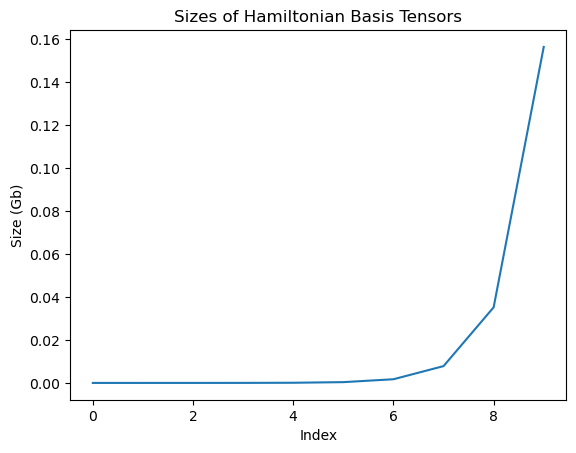

In [15]:
import matplotlib.pyplot as plt
import sys

bytes_in_gb = 1024**3

# Get the sizes of Hamiltonians
sizes = [
    hamiltonian.basis.element_size() * hamiltonian.basis.numel() / bytes_in_gb
    for hamiltonian in Hamiltonians
]

# Plot the sizes
plt.plot(sizes)
plt.xlabel("Index")
plt.ylabel("Size (Gb)")
plt.title("Sizes of Hamiltonian Basis Tensors")
plt.show()

In [16]:
def tensorsize(tensor):
    return tensor.element_size() * tensor.numel() / bytes_in_gb

In [17]:
ham = Hamiltonians[9]
tensorsize(ham.connections)

2.980232238769531e-07

In [18]:
ham.connections

tensor([[ 0,  1],
        [ 1,  2],
        [ 2,  3],
        [ 3,  4],
        [ 4,  5],
        [ 5,  6],
        [ 6,  7],
        [ 7,  8],
        [ 8,  9],
        [ 9, 10],
        [10, 11],
        [11, 12],
        [12, 13],
        [13, 14],
        [14, 15],
        [15, 16],
        [16, 17],
        [17, 18],
        [18, 19],
        [19,  0]], device='cuda:0')

In [19]:
param_dim = Hamiltonians[0].param_dim
embedding_size = 32
n_head = 8
n_hid = embedding_size
n_layers = 8
dropout = 0
minibatch = 1000
param_range = None
point_of_interest = None
use_SR = False

In [20]:
# Small allocation for model parameters, layers, etc.
testmodel = TransformerModel(
    system_sizes,
    param_dim,
    embedding_size,
    n_head,
    n_hid,
    n_layers,
    dropout=dropout,
    minibatch=minibatch,
)

/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/utils/_device.py:78: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return func(*args, **kwargs)
/home/spandan/anaconda3/envs/tqs2/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer was not TransformerEncoderLayer
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


In [21]:
testmodel.cuda()

TransformerModel(
  (pos_encoder): TQSPositionalEncoding1D(
    (dropout): Dropout(p=0, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-7): 8 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Linear(in_features=32, out_features=32, bias=True)
          (linear_Q): Linear(in_features=32, out_features=32, bias=True)
          (linear_K): Linear(in_features=32, out_features=32, bias=True)
          (linear_V): Linear(in_features=32, out_features=32, bias=True)
        )
        (linear1): Linear(in_features=32, out_features=32, bias=True)
        (dropout): Dropout(p=0, inplace=False)
        (linear2): Linear(in_features=32, out_features=32, bias=True)
        (norm1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0, inplace=False)
        (dropout2): Dropout(p=0, inplace=False)
      )
    )


In [22]:
opt = Optimizer(testmodel, Hamiltonians, point_of_interest=point_of_interest)

In [23]:
param_range = torch.tensor([[0.5, 1.5]])
param_step = torch.tensor([0.01])

In [24]:
pgen = opt.generate_parameter_points(param_range, param_step)

In [25]:
for point in pgen:
    pointtens = torch.tensor(point, device="cuda")
    print(pointtens)

tensor([0.5000], device='cuda:0')
tensor([0.5100], device='cuda:0')
tensor([0.5200], device='cuda:0')
tensor([0.5300], device='cuda:0')
tensor([0.5400], device='cuda:0')
tensor([0.5500], device='cuda:0')
tensor([0.5600], device='cuda:0')
tensor([0.5700], device='cuda:0')
tensor([0.5800], device='cuda:0')
tensor([0.5900], device='cuda:0')
tensor([0.6000], device='cuda:0')
tensor([0.6100], device='cuda:0')
tensor([0.6200], device='cuda:0')
tensor([0.6300], device='cuda:0')
tensor([0.6400], device='cuda:0')
tensor([0.6500], device='cuda:0')
tensor([0.6600], device='cuda:0')
tensor([0.6700], device='cuda:0')
tensor([0.6800], device='cuda:0')
tensor([0.6900], device='cuda:0')
tensor([0.7000], device='cuda:0')
tensor([0.7100], device='cuda:0')
tensor([0.7200], device='cuda:0')
tensor([0.7300], device='cuda:0')
tensor([0.7400], device='cuda:0')
tensor([0.7500], device='cuda:0')
tensor([0.7600], device='cuda:0')
tensor([0.7700], device='cuda:0')
tensor([0.7800], device='cuda:0')
tensor([0.7900

In [26]:
torch.cuda.memory_allocated() / bytes_in_gb

0.20179128646850586

In [27]:
epochs = 100

In [28]:
import cProfile

In [29]:
with cProfile.Profile() as pr:
    opt.train(
        epochs=epochs, param_range=param_range, param_step=param_step, start_iter=0
    )

Ran forward for tensor([2]) spins at point (0.5,)
Ran forward for tensor([2]) spins at point (0.5099999997764826,)
Ran forward for tensor([2]) spins at point (0.5199999995529652,)
Ran forward for tensor([2]) spins at point (0.5299999993294477,)
Ran forward for tensor([2]) spins at point (0.5399999991059303,)
Ran forward for tensor([2]) spins at point (0.5499999988824129,)
Ran forward for tensor([2]) spins at point (0.5599999986588955,)
Ran forward for tensor([2]) spins at point (0.5699999984353781,)
Ran forward for tensor([2]) spins at point (0.5799999982118607,)
Ran forward for tensor([2]) spins at point (0.5899999979883432,)
Ran forward for tensor([2]) spins at point (0.5999999977648258,)
Ran forward for tensor([2]) spins at point (0.6099999975413084,)
Ran forward for tensor([2]) spins at point (0.619999997317791,)
Ran forward for tensor([2]) spins at point (0.6299999970942736,)
Ran forward for tensor([2]) spins at point (0.6399999968707561,)
Ran forward for tensor([2]) spins at poin

/home/spandan/Projects/tqs/model.py:228: SyntaxWarning: invalid escape sequence '\p'
  """


KeyboardInterrupt: 

In [ ]:
pr.print_stats()

         4666348 function calls (3954845 primitive calls) in 5.515 seconds

   Ordered by: standard name

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
   762000    2.049    0.000    3.767    0.000 _device.py:74(__torch_function__)
     1500    0.002    0.000    0.011    0.000 _tensor.py:1037(__iter__)
        1    0.000    0.000    0.000    0.000 base_events.py:1908(_run_once)
        4    0.000    0.000    0.000    0.000 base_events.py:732(time)
        1    0.000    0.000    0.000    0.000 cProfile.py:119(__exit__)
        1    0.000    0.000    0.000    0.000 decorator.py:199(fix)
        1    0.000    0.000    0.010    0.010 decorator.py:229(fun)
        1    0.000    0.000    0.000    0.000 events.py:127(__lt__)
        2    0.000    0.000    0.000    0.000 events.py:86(_run)
        1    0.000    0.000    0.000    0.000 functools.py:35(update_wrapper)
        1    0.000    0.000    0.000    0.000 functools.py:65(wraps)
        1    0.000    0.000    0.0

In [ ]:
pr.dump_stats("profilestats")

In [ ]:
loss = opt.calculate_mse_step(
    Hamiltonians[0], params=torch.tensor([1.0], device="cuda"), use_symmetry=True
)

ValueError: Ground states not loaded yet. See load_dataset.

In [ ]:
H = Hamiltonians[9]

In [ ]:
from model_utils import compute_psi

In [ ]:
basis = H.basis
symmetry = H.symmetry
log_amp, log_phase = compute_psi(testmodel, basis, symmetry)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat2 in method wrapper_CUDA_mm)

In [ ]:
spins = H.basis
spins

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1]], device='cuda:0')

In [ ]:
testmodel.src_mask.cuda()

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]], device='cuda:0')

## .forward()

Let's follow .forward() to find bottlenecks.


In [ ]:
H = Hamiltonians[9]

In [ ]:
H.system_size

tensor([20])

In [ ]:
spins = H.basis
spins

tensor([[0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 0,  ..., 1, 1, 1],
        ...,
        [0, 0, 0,  ..., 1, 1, 1],
        [0, 0, 1,  ..., 0, 1, 1],
        [0, 1, 0,  ..., 1, 0, 1]], device='cuda:0')

In [ ]:
testmodel.set_param(system_size=H.system_size, param=torch.tensor([1.0], device="cuda"))

In [ ]:
src = testmodel.wrap_spins(spins)
src

tensor([[[0.0000, 0.0000, 2.9957, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 2.9957, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 2.9957, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 0.0000, 2.9957, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 2.9957, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 2.9957, 0.0000, 0.0000, 0.0000]],

        [[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         ...,
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]],

        [[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         ...,
         [0.0000, 1.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [

In [ ]:
src.shape

torch.Size([22, 1048576, 6])

In [ ]:
src.device

device(type='cuda', index=0)

In [ ]:
testmodel.src_mask

In [ ]:
testmodel.src_mask = testmodel._generate_square_subsequent_mask(src.size(0)).to(
    src.device
)
testmodel.src_mask

tensor([[0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf, -inf],
        [0., 0., 0., 0., 0., 0., 0., 0., -inf, -inf, -inf, -in

In [ ]:
print(testmodel.n_dim)
print(testmodel.phys_dim)

1
2


In [ ]:
system_size = src[
    : testmodel.n_dim, 0, testmodel.phys_dim : testmodel.phys_dim + testmodel.n_dim
].diag()
system_size

tensor([2.9957], device='cuda:0')

In [ ]:
system_size = system_size.exp().round().to(torch.int64)
system_size

tensor([20], device='cuda:0')

In [ ]:
2**21

2097152

In [ ]:
import math

In [ ]:
torch.set_default_device("cuda")

In [ ]:
src = testmodel.encoder(src) * math.sqrt(testmodel.embedding_size)
src

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_CUDA_addmm)

In [ ]:
src = testmodel.pos_encoder(src)
src

tensor([[[-1.2558, -0.1955, -0.1439,  ...,  0.7043,  1.1742,  0.7694],
         [-1.2558, -0.1955, -0.1439,  ...,  0.7043,  1.1742,  0.7694],
         [-1.2558, -0.1955, -0.1439,  ...,  0.7043,  1.1742,  0.7694],
         ...,
         [-1.2558, -0.1955, -0.1439,  ...,  0.7043,  1.1742,  0.7694],
         [-1.2558, -0.1955, -0.1439,  ...,  0.7043,  1.1742,  0.7694],
         [-1.2558, -0.1955, -0.1439,  ...,  0.7043,  1.1742,  0.7694]],

        [[ 0.0594, -0.1669, -0.1766,  ..., -0.3560, -0.3450, -0.0269],
         [ 0.0594, -0.1669, -0.1766,  ..., -0.3560, -0.3450, -0.0269],
         [ 0.0594, -0.1669, -0.1766,  ..., -0.3560, -0.3450, -0.0269],
         ...,
         [ 0.0594, -0.1669, -0.1766,  ..., -0.3560, -0.3450, -0.0269],
         [ 0.0594, -0.1669, -0.1766,  ..., -0.3560, -0.3450, -0.0269],
         [ 0.0594, -0.1669, -0.1766,  ..., -0.3560, -0.3450, -0.0269]],

        [[ 0.1011,  1.4968,  0.0705,  ...,  0.9532, -0.0762,  0.9932],
         [ 0.1011,  1.4968,  0.0705,  ...,  0

In [ ]:
# output = testmodel.transformer_encoder(src, testmodel.src_mask)

AssertionError: 